In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.eval_utils import join_real_generated

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right
from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt 
matplotlib.rcdefaults()

from pathlib import Path
matplotlib_rc = { 
    # 'text': {'usetex': True}, 
    'font': {'family': 'serif'} } # Apply changes for k, v in matplotlib_rc.items(): rc(k, **v)
for k, v in matplotlib_rc.items():
          rc(k, **v)

from matplotlib import rcParams

FIGSIZE = (3, 3)
rcParams["figure.figsize"] = FIGSIZE

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Initialize dataset

In [2]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'tabula_muris' / 'tabula_muris_test.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['mouse.id', 'tissue'],
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 128, 
                    'multimodal': False, 
                    'is_binarized': False,
                    'theta_covariate': 'tissue', 
                    'size_factor_covariate': 'mouse.id',
                 }

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"]
                      )

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [3]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False, 
    "multimodal": False,
    "is_binarized": False}


state_dict_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_train_autoencoder_tabula_muris_whole_genome/df8d1d1a-085d-403c-8323-beb4c5a3f4cd/checkpoints/epoch_79.ckpt"

In [4]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=None,
                              conditioning_covariate=dataset_config["theta_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initialize FM model

In [5]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [6]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/GUIDED_MULTILAB_TABULA/d728053e-845a-4694-8a2d-87b1edacba57/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [7]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["tissue"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-0.6640,  0.4273,  1.8468,  ..., -0.1990,  1.2057, -1.1594],
        [-0.2286,  0.1446,  0.2920,  ...,  0.8657, -0.3779,  0.6156],
        [-0.4705,  0.8370,  1.4127,  ...,  0.4333,  0.9601,  2.1163],
        ...,
        [-0.1796,  0.7269, -0.5031,  ...,  0.7551,  0.0210, -1.3099],
        [-0.5902,  0.5471,  1.0582,  ..., -0.8938,  0.6386,  0.6946],
        [ 0.4402, -1.1965, -0.2755,  ..., -0.1655,  0.2384, -0.8475]],
       device='cuda:0', requires_grad=True)


Initializations

In [8]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'tissue': 2, 'mouse.id': 2},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=19734, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
       

In [9]:
generative_model.denoising_model.guided_conditioning = True

**Check the data**

In [10]:
adata_original = sc.read_h5ad(data_path)
sc.pp.subsample(adata_original, 0.5)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
adata_original.X = adata_original.layers["X_counts"].A.copy()
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [11]:
adata_original

AnnData object with n_obs × n_vars = 24539 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'size_factor'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

## Train oracles

In [12]:
from oracle_training import train_mlp_classifier
oracle_tissue,le_tissue = train_mlp_classifier(adata_original,
                     "tissue", 
                     hidden_layer_sizes=(64, 32),
                     epochs=300,
                     batch_size=32,
                     lr=0.001, 
                     device='cuda')

Epoch 10/300, Loss: 0.0071
Test Accuracy: 0.9032
Epoch 20/300, Loss: 0.1462
Test Accuracy: 0.9234
Epoch 30/300, Loss: 0.0075
Test Accuracy: 0.9144
Epoch 40/300, Loss: 0.0074
Test Accuracy: 0.9136
Epoch 50/300, Loss: 0.0018
Test Accuracy: 0.9216
Epoch 60/300, Loss: 0.0000
Test Accuracy: 0.9211
Epoch 70/300, Loss: 0.0003
Test Accuracy: 0.9340
Epoch 80/300, Loss: 0.0000
Test Accuracy: 0.9348
Epoch 90/300, Loss: 0.0000
Test Accuracy: 0.9326
Epoch 100/300, Loss: 0.0000
Test Accuracy: 0.9218
Epoch 110/300, Loss: 0.0000
Test Accuracy: 0.9240
Epoch 120/300, Loss: 0.0000
Test Accuracy: 0.9315
Epoch 130/300, Loss: 0.0077
Test Accuracy: 0.9267
Epoch 140/300, Loss: 0.0011
Test Accuracy: 0.9342
Epoch 150/300, Loss: 0.0000
Test Accuracy: 0.9209
Epoch 160/300, Loss: 0.0000
Test Accuracy: 0.9319
Epoch 170/300, Loss: 0.0000
Test Accuracy: 0.9301
Epoch 180/300, Loss: 0.0000
Test Accuracy: 0.9203
Epoch 190/300, Loss: 0.0015
Test Accuracy: 0.9313
Epoch 200/300, Loss: 0.0000
Test Accuracy: 0.9299
Epoch 210

In [13]:
oracle_donor,le_donor = train_mlp_classifier(adata_original,
                     "mouse.id", 
                     hidden_layer_sizes=(64, 32),
                     epochs=300,
                     batch_size=32,
                     lr=0.001, 
                     device='cuda')

Epoch 10/300, Loss: 0.6683
Test Accuracy: 0.5134
Epoch 20/300, Loss: 0.3240
Test Accuracy: 0.5654
Epoch 30/300, Loss: 0.0771
Test Accuracy: 0.5581
Epoch 40/300, Loss: 0.0268
Test Accuracy: 0.5852
Epoch 50/300, Loss: 0.0848
Test Accuracy: 0.5825
Epoch 60/300, Loss: 0.1773
Test Accuracy: 0.5831
Epoch 70/300, Loss: 0.0179
Test Accuracy: 0.5554
Epoch 80/300, Loss: 0.2528
Test Accuracy: 0.5363
Epoch 90/300, Loss: 0.0637
Test Accuracy: 0.5668
Epoch 100/300, Loss: 0.0007
Test Accuracy: 0.5770
Epoch 110/300, Loss: 0.0028
Test Accuracy: 0.5691
Epoch 120/300, Loss: 0.0374
Test Accuracy: 0.5662
Epoch 130/300, Loss: 0.0469
Test Accuracy: 0.5789
Epoch 140/300, Loss: 0.9485
Test Accuracy: 0.5387
Epoch 150/300, Loss: 0.0038
Test Accuracy: 0.5434
Epoch 160/300, Loss: 0.0011
Test Accuracy: 0.5799
Epoch 170/300, Loss: 0.0032
Test Accuracy: 0.5701
Epoch 180/300, Loss: 0.0077
Test Accuracy: 0.5658
Epoch 190/300, Loss: 0.0013
Test Accuracy: 0.5650
Epoch 200/300, Loss: 0.2950
Test Accuracy: 0.5573
Epoch 210

## Generate intersection

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


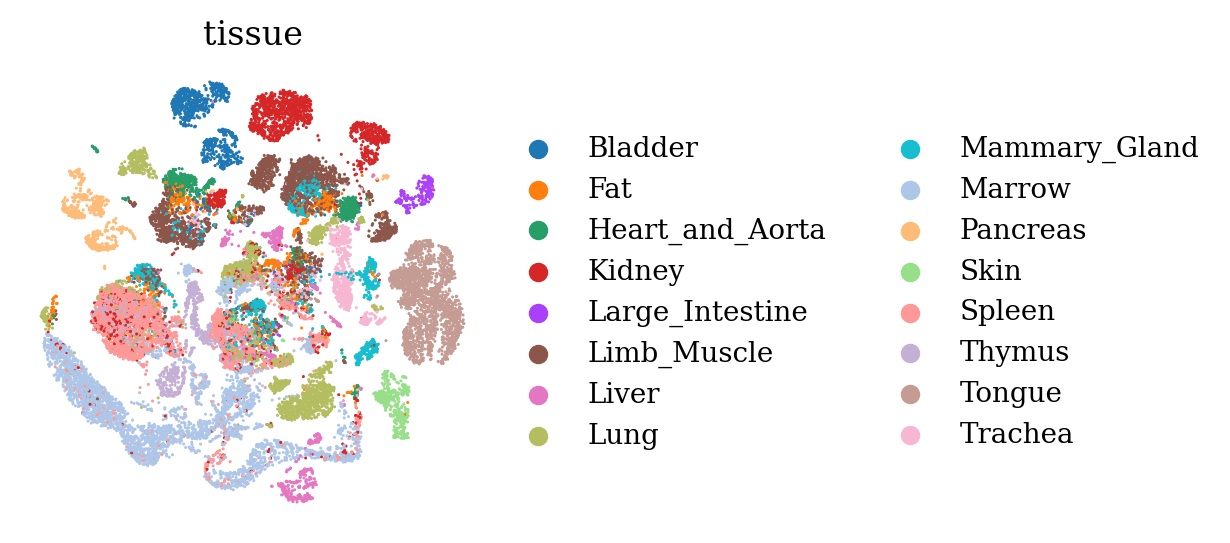

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


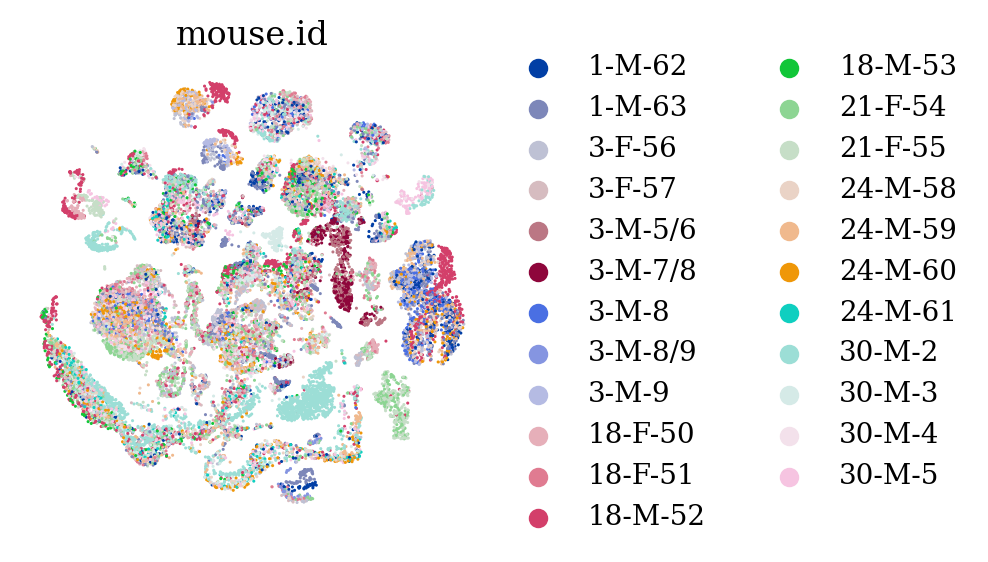

In [14]:
sc.pl.umap(adata_original, color="tissue")
sc.pl.umap(adata_original, color="mouse.id")

# COMBINATION OF CONDITIONS 

Standard guide weights (default)

In [15]:
generative_model.guidance_weights

{'tissue': 2, 'mouse.id': 2}

Check combinations of attributes

In [16]:
pd.crosstab(adata_original.obs.tissue, adata_original.obs["mouse.id"])

mouse.id,1-M-62,1-M-63,3-F-56,3-F-57,3-M-5/6,3-M-7/8,3-M-8,3-M-8/9,3-M-9,18-F-50,...,21-F-54,21-F-55,24-M-58,24-M-59,24-M-60,24-M-61,30-M-2,30-M-3,30-M-4,30-M-5
tissue,,,,,,,,,,,,,,,,,,,,,
Bladder,0,94,49,0,0,0,12,0,178,0,...,0,0,128,106,97,0,0,0,0,0
Fat,0,0,0,0,0,0,0,0,0,144,...,39,32,0,0,0,0,0,0,0,196
Heart_and_Aorta,0,97,55,0,0,0,0,0,0,52,...,44,39,47,27,0,0,370,17,0,0
Kidney,128,118,0,114,0,0,60,0,87,76,...,111,106,305,282,0,0,189,123,124,107
Large_Intestine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,52,0,36,101
Limb_Muscle,313,298,171,171,0,0,0,0,0,97,...,153,197,172,172,169,171,0,0,176,147
Liver,45,228,33,13,0,0,0,51,0,0,...,37,0,8,1,0,0,0,190,7,39
Lung,103,167,41,86,60,163,0,0,0,39,...,110,165,0,0,0,0,792,164,105,48
Mammary_Gland,0,0,210,256,0,0,0,0,0,172,...,256,239,0,0,0,0,0,0,0,0


In [17]:
# Pick condition - pick specific condition (Tongue and 18-M-52)
covariates_tissue = 'Tongue'
covariates_mouse_id = '18-M-52'

condition_id_clus = dataset.id2cov["tissue"][covariates_tissue]
condition_id_mouse_id = dataset.id2cov["mouse.id"][covariates_mouse_id]

adata_cond = adata_original[np.logical_and(adata_original.obs.tissue==covariates_tissue, 
                                           adata_original.obs["mouse.id"]==covariates_mouse_id)]
n_to_generate = adata_cond.shape[0]

classes = {"tissue": condition_id_clus*torch.ones(n_to_generate).long(), 
           "mouse.id": condition_id_mouse_id*torch.ones(n_to_generate).long()}

classes_str = {"tissue": [covariates_tissue for n in range(n_to_generate)], 
           "mouse.id": [covariates_mouse_id for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

First: generation with default guidance weights

In [18]:
X_generated = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        theta_covariate="a", 
                                        size_factor_covariate="mouse.id",
                                        conditioning_covariates=["tissue", "mouse.id"],
                                        covariate_indices=classes, 
                                        log_size_factor=None)

X_generated = X_generated.to("cpu")
adata_generated = sc.AnnData(X=X_generated.numpy())

In [19]:
adata_merged = join_real_generated(adata_original, adata_generated, True, classes_str, ["tissue", "mouse.id"])

In [20]:
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

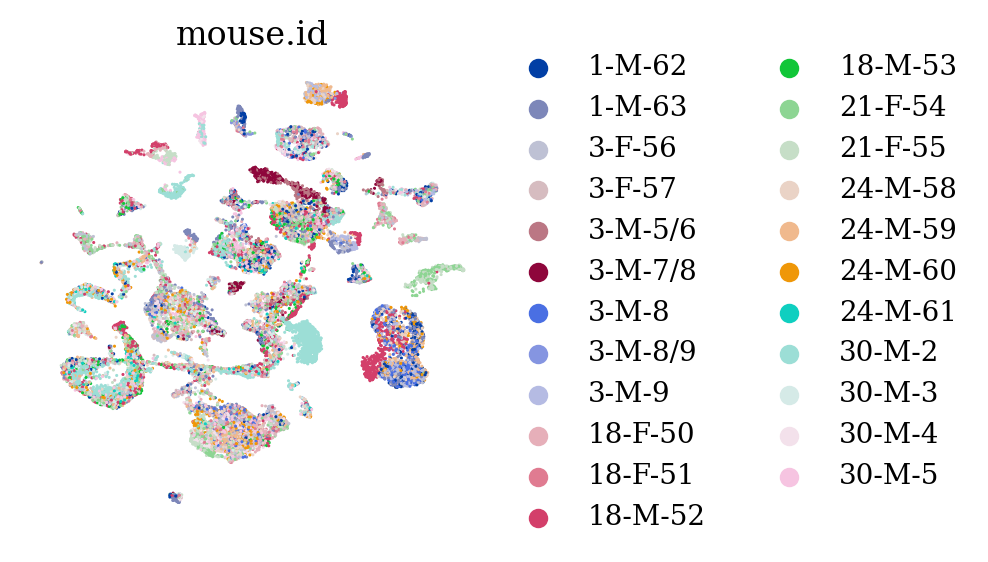

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

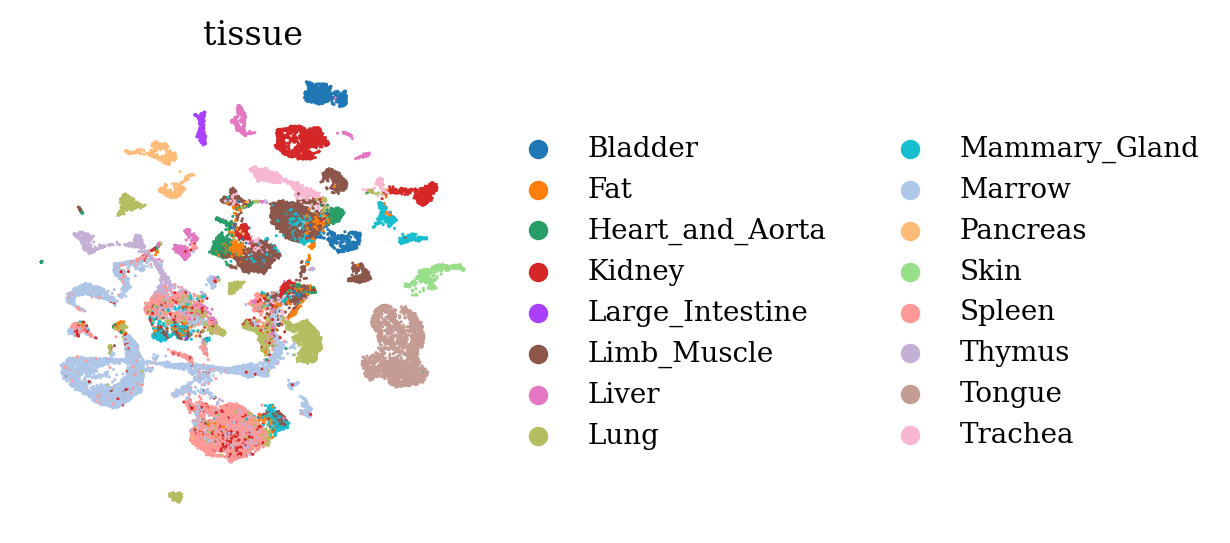

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


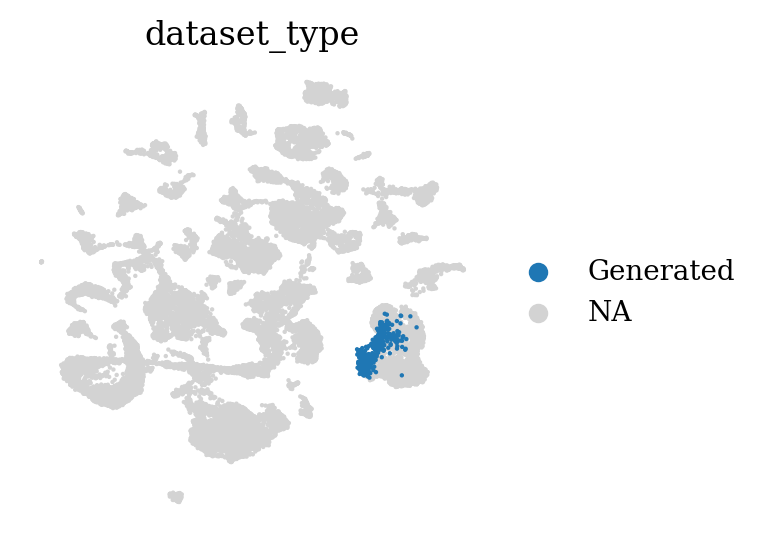

In [21]:
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="mouse.id")
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="tissue")
sc.pl.umap(adata_merged, color="dataset_type", groups="Generated", s=10)

In [22]:
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


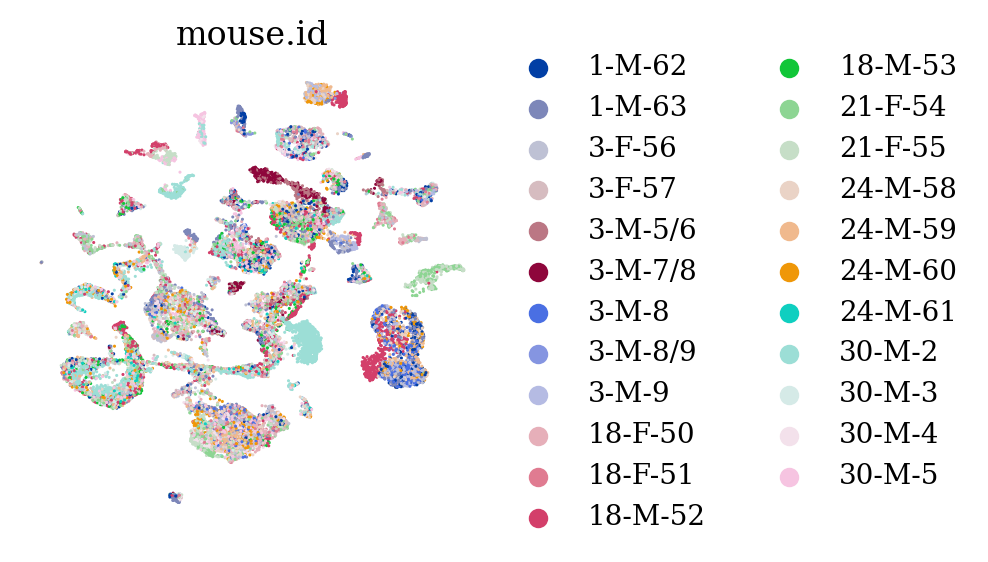

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


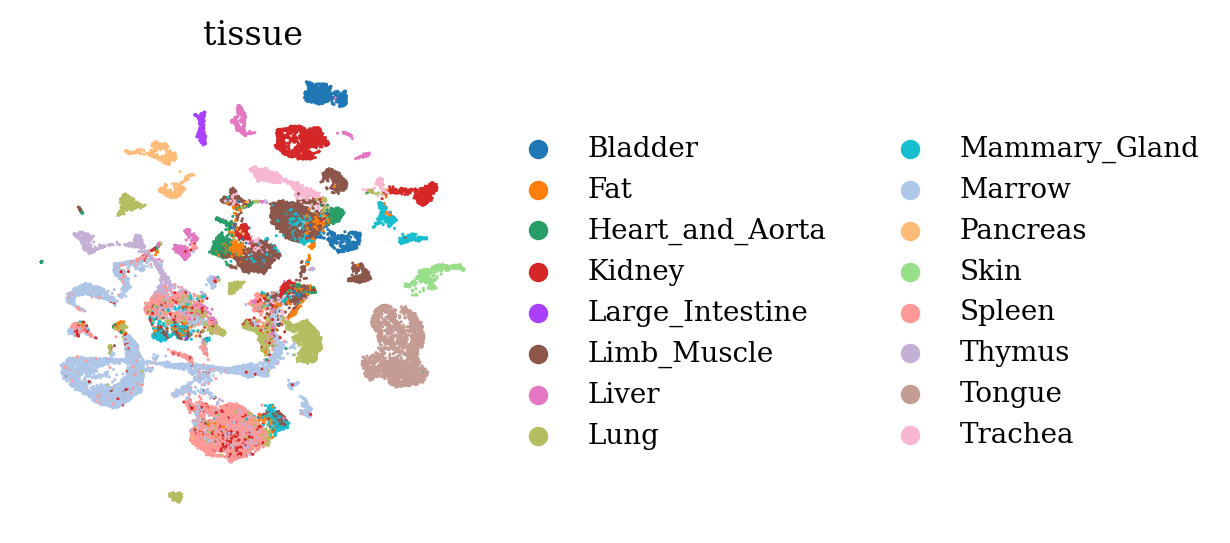

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


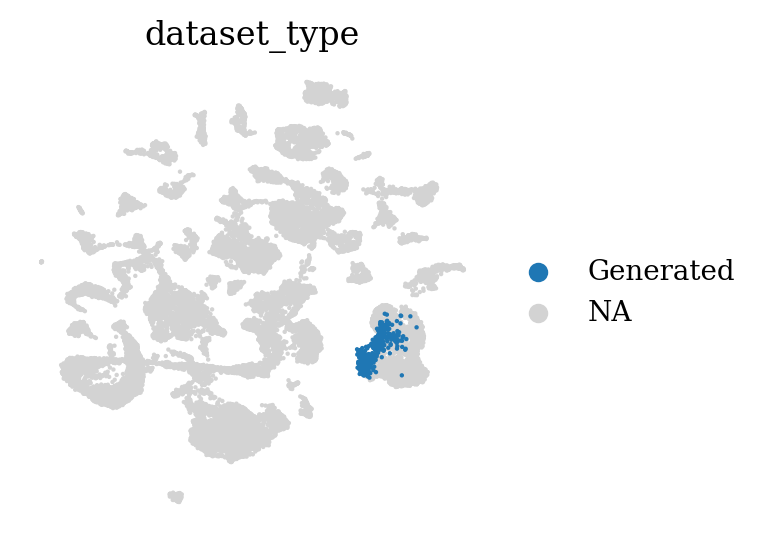

In [23]:
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="mouse.id")
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="tissue")
sc.pl.umap(adata_merged, color="dataset_type", groups="Generated", s=10)

## Experiment guidance weights

Generate from multiple combinations of guidance weights

In [24]:
results_oracle = {"weight_step": [],
                    "tissue_pred": [],
                    "mouse_id_pred": []
                  }

In [25]:
covariates_tissue = 'Tongue'
covariates_mouse_id = '18-M-52'

mouse_id_weight_data = {}

condition_id_clus = dataset.id2cov["tissue"][covariates_tissue]
condition_id_mouse_id = dataset.id2cov["mouse.id"][covariates_mouse_id]

adata_cond = adata_original[np.logical_and(adata_original.obs.tissue==covariates_tissue, 
                                           adata_original.obs["mouse.id"]==covariates_mouse_id)]
n_to_generate = 500

classes = {"tissue": condition_id_clus*torch.ones(n_to_generate).long(), 
           "mouse.id": condition_id_mouse_id*torch.ones(n_to_generate).long()}

classes_str = {"tissue": [covariates_tissue for n in range(n_to_generate)], 
           "mouse.id": [covariates_mouse_id for n in range(n_to_generate)]}

for mouse_id_weight in [0, 1, 1.5, 2.5]:
    X_generated = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=2, 
                                        theta_covariate="tissue", 
                                        size_factor_covariate="tissue",
                                        conditioning_covariates=["tissue", "mouse.id"],
                                        covariate_indices=classes, 
                                        log_size_factor=None, 
                                        guidance_weights={'tissue': 1, 'mouse.id': mouse_id_weight})

    with torch.no_grad():
        results_oracle["weight_step"] += [mouse_id_weight] * X_generated.shape[0]
        results_oracle["tissue_pred"].append(torch.softmax(oracle_tissue(X_generated), dim=1)[:, condition_id_clus].cpu().numpy())
        results_oracle["mouse_id_pred"].append(torch.softmax(oracle_donor(X_generated), dim=1)[:, condition_id_mouse_id].cpu().numpy())
    
    X_generated = X_generated.to("cpu")
        
    mouse_id_weight_data[mouse_id_weight] = X_generated

In [26]:
results_oracle["tissue_pred"] = np.concatenate(results_oracle["tissue_pred"])
results_oracle["mouse_id_pred"] = np.concatenate(results_oracle["mouse_id_pred"])

In [27]:
results_oracle = pd.DataFrame(results_oracle)

In [28]:
results_oracle.groupby("weight_step").mean()

,tissue_pred,mouse_id_pred
weight_step,,
0.0,0.983973,0.187347
1.0,0.982001,0.691171
1.5,0.976000,0.868723
2.5,0.964000,0.967664


In [29]:
adata_joint_mat = [adata_original.layers["X_counts"].A.copy()]
weights = ["Real data" for _ in range(len(adata_joint_mat[0]))]
tissue = list(adata_original.obs["tissue"])
mouse_id = list(adata_original.obs["mouse.id"])

for w in mouse_id_weight_data:
    adata_joint_mat.append(mouse_id_weight_data[w])
    weights += [str(w) for _ in range(len(mouse_id_weight_data[w]))]
    tissue += ["g_Tongue" for _ in range(len(mouse_id_weight_data[w]))]
    mouse_id += ['g_18-M-52' for _ in range(len(mouse_id_weight_data[w]))]

In [30]:
obs = pd.DataFrame(weights)
obs.columns = ["guidance weight"]
obs["tissue"] = tissue
obs["mouse.id"] = mouse_id

In [31]:
adata_joint = sc.AnnData(X=np.concatenate(adata_joint_mat,axis=0),
                        obs=obs)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
sc.pp.normalize_total(adata_joint, target_sum=1e4)
sc.pp.log1p(adata_joint)
sc.tl.pca(adata_joint)
sc.pp.neighbors(adata_joint)
sc.tl.umap(adata_joint)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


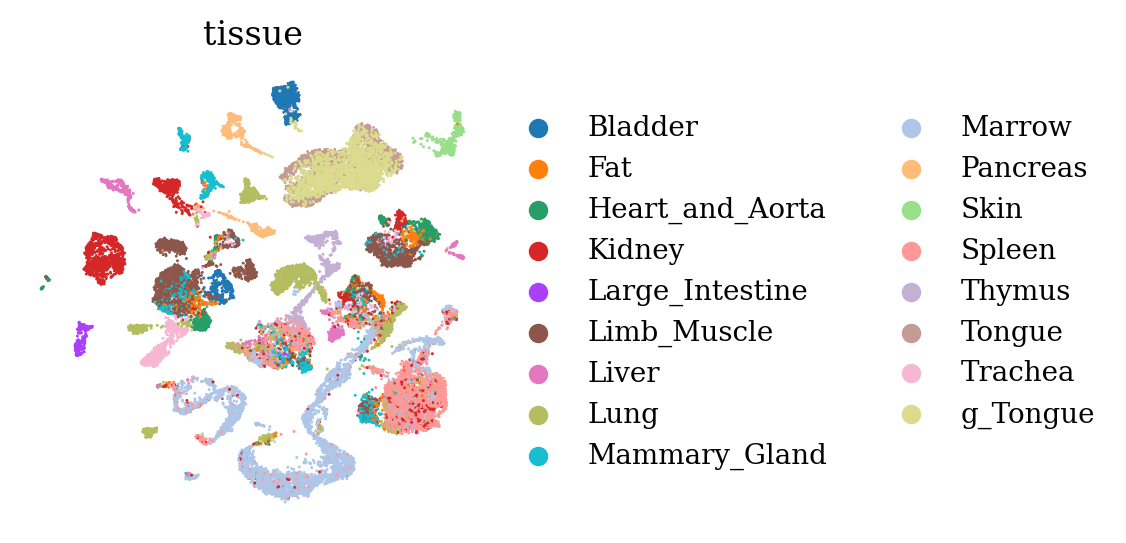

In [33]:
sc.pl.umap(adata_joint, color="tissue")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


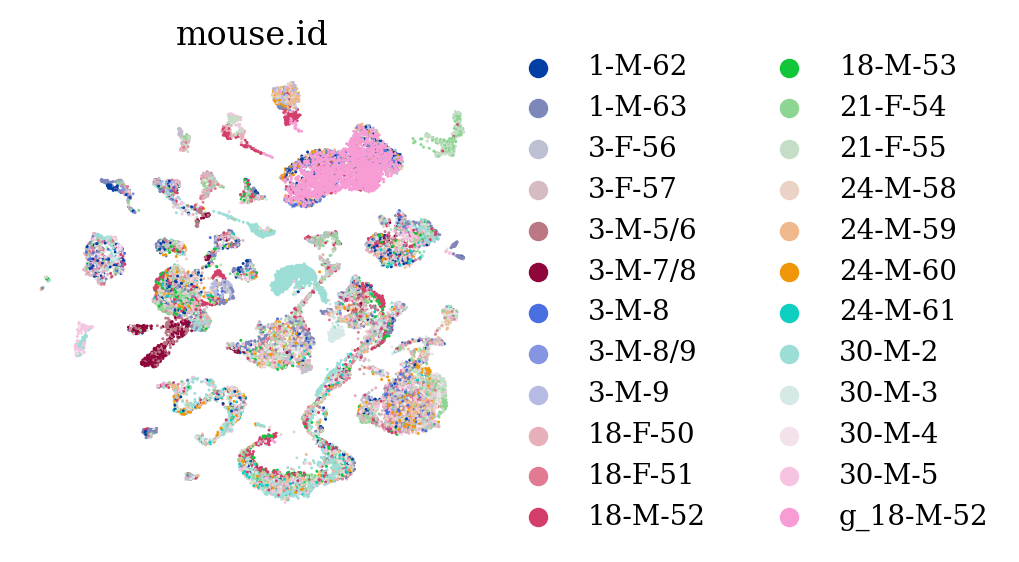

In [34]:
sc.pl.umap(adata_joint, color="mouse.id")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


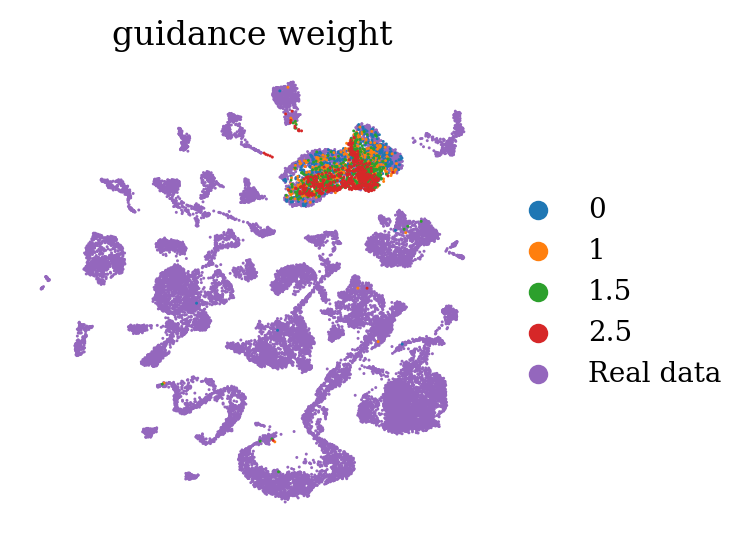

In [35]:
sc.pl.umap(adata_joint, color="guidance weight")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


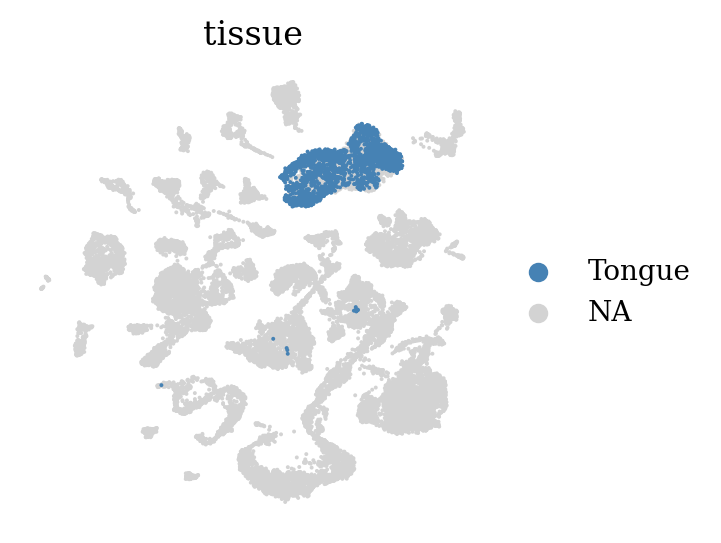

In [38]:
adata_joint.uns["tissue_colors"][14]="steelblue"
sc.pl.umap(adata_joint, color='tissue', groups="Tongue",s=8,save="real_tabula_tongue.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


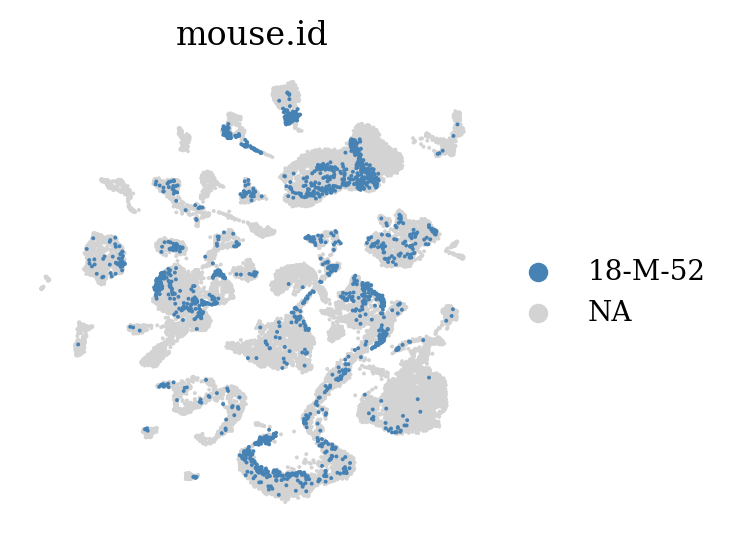

In [40]:
adata_joint.uns["mouse.id_colors"][11]="steelblue"
sc.pl.umap(adata_joint, color='mouse.id', groups='18-M-52',s=8,save="real_tabula_18m52.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


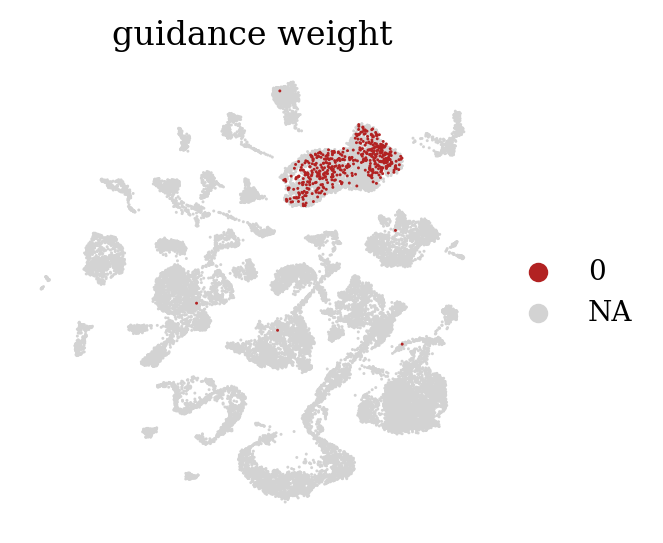

In [41]:
adata_joint.uns["guidance weight_colors"][0] = "firebrick"
sc.pl.umap(adata_joint, color='guidance weight', groups="0", save="tabula_tongue_18m52_0.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


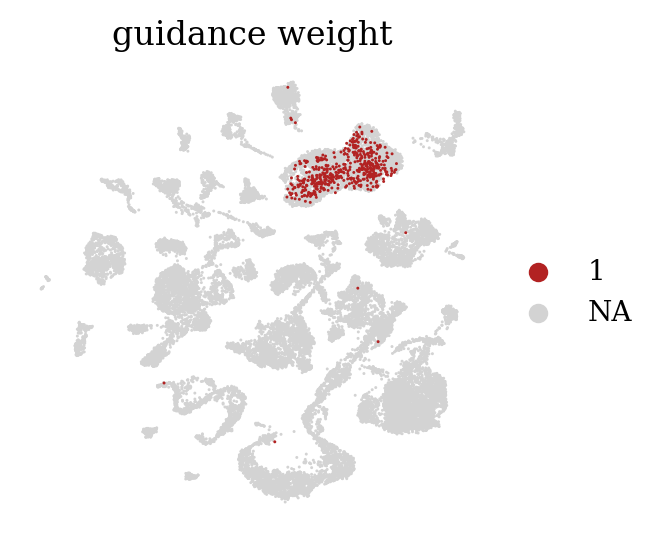

In [42]:
adata_joint.uns["guidance weight_colors"][1] = "firebrick"
sc.pl.umap(adata_joint, color='guidance weight', groups="1", save="tabula_tongue_18m52_1.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


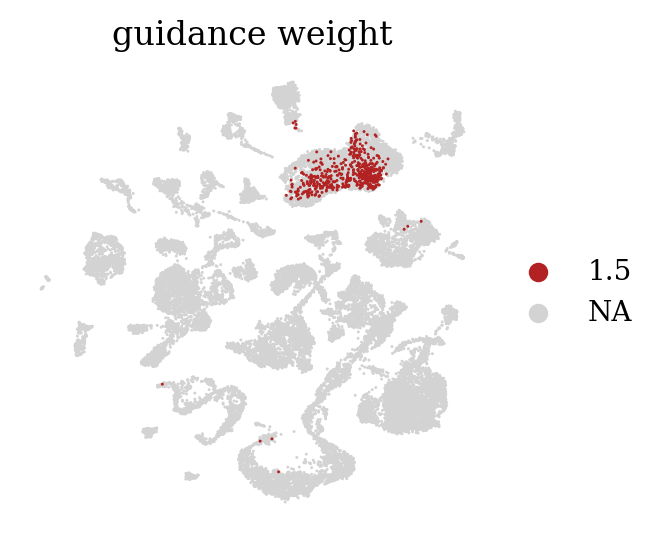

In [43]:
adata_joint.uns["guidance weight_colors"][2] = "firebrick"
sc.pl.umap(adata_joint, color='guidance weight', groups="1.5", save="tabula_tongue_18m52_15.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


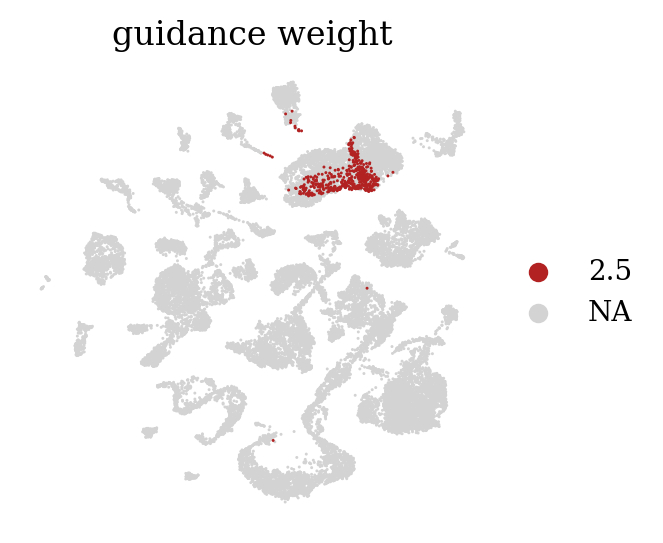

In [44]:
adata_joint.uns["guidance weight_colors"][3] = "firebrick"
sc.pl.umap(adata_joint, color='guidance weight', groups="2.5", save="tabula_tongue_18m52_25.png")

Add uncond generation

In [45]:
classes = {"tissue": condition_id_clus*torch.ones(24539).long(), 
           "mouse.id": condition_id_mouse_id*torch.ones(24539).long()}
X_generated_uncond = generative_model.sample(batch_size=24539,
                                    n_sample_steps=2, 
                                    theta_covariate="tissue", 
                                    size_factor_covariate="tissue",
                                    conditioning_covariates=["tissue", "mouse.id"],
                                    covariate_indices=classes, 
                                    log_size_factor=torch.log(torch.tensor(adata_original.layers["X_counts"].sum(1))).cuda(), 
                                    guidance_weights={'tissue': 0, 'mouse.id': 0})

X_generated_uncond = X_generated_uncond.to("cpu")

In [46]:
gener_uncond = sc.AnnData(X = X_generated_uncond.numpy())

In [47]:
adata_joint_uncond = sc.AnnData(X=np.concatenate([adata_original.layers["X_counts"].A, gener_uncond.X], axis=0), 
                               obs={"dataset_type":["Real" for _ in range(len(adata_original))]+["Generated" for _ in range(len(gener_uncond))]})

In [48]:
sc.pp.normalize_total(adata_joint_uncond, target_sum=1e4)
sc.pp.log1p(adata_joint_uncond)

In [49]:
sc.tl.pca(adata_joint_uncond)
sc.pp.neighbors(adata_joint_uncond)
sc.tl.umap(adata_joint_uncond)

In [51]:
# Load the Set1 color palette from matplotlib
set1_palette = plt.get_cmap('Set1').colors

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


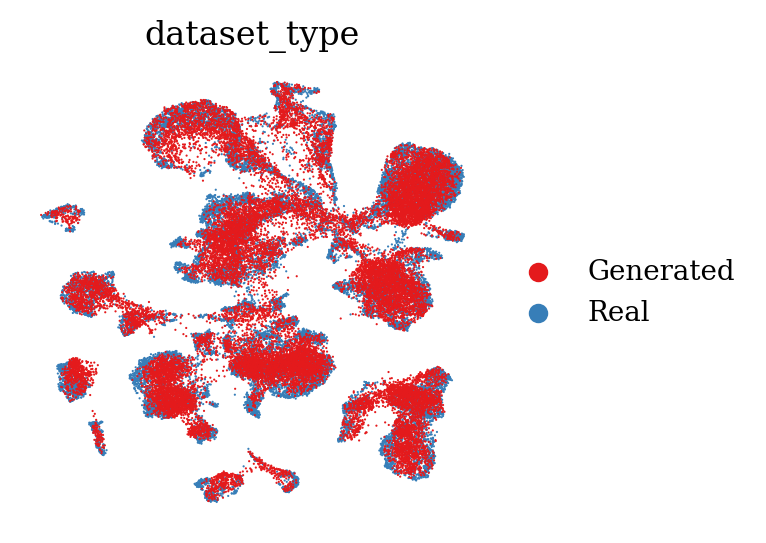

In [52]:
# sc.pl.umap(adata_joint_uncond[np.random.permutation(np.arange(len(adata_joint_uncond)))], color="dataset_type", palette=set1_palette, save="tabula_0_0.png")
sc.pl.umap(adata_joint_uncond, color="dataset_type", palette=set1_palette, save="tabula_0_0.svg")

In [49]:
# classes = {"tissue": condition_id_clus*torch.ones(12000).long(), 
#            "mouse.id": condition_id_mouse_id*torch.ones(12000).long()}
# X_generated_uncond = generative_model.sample(batch_size=12000,
#                                     n_sample_steps=2, 
#                                     theta_covariate="cell_type", 
#                                     size_factor_covariate="cell_type",
#                                     conditioning_covariates=["cell_type", "DonorNumber"],
#                                     covariate_indices=classes, 
#                                     log_size_factor=None, 
#                                     guidance_weights={'cell_type': 0, 'DonorNumber': 0})

# X_generated_uncond = X_generated.to("cpu")